## Load the data:

In [1]:
import warnings
import numpy as np
import pandas as pd
import os

# Suppress specific UserWarnings from openpyxl
warnings.filterwarnings("ignore", category=UserWarning, module='openpyxl')

# Define the directory where your files are located
# data_dir = '.' 
data_dir = os.path.join(os.path.pardir)  

# List to hold the dataframes
dataframes = []

# Loop through the years and load the files
for year in range(2005, 2020):
    if year <= 2012:
        file_path = os.path.join(data_dir, f'{year}.xls')
    else:
        file_path = os.path.join(data_dir, f'{year}.xlsx')
    
    # Load the file into a dataframe
    df = pd.read_excel(file_path)
    
    # Append the dataframe to the list
    dataframes.append(df)

# Concatenate all the dataframes into one
betting_data = pd.concat(dataframes, ignore_index=True)

# Display the first few rows of the combined dataframe
betting_data.head()


,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,UBW,UBL,LBW,LBL,SJW,SJL,MaxW,MaxL,AvgW,AvgL
0,1,Adelaide,Next Generation Hardcourts,2005-01-03,International,Outdoor,Hard,1st Round,3,Saulnier C.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Adelaide,Next Generation Hardcourts,2005-01-03,International,Outdoor,Hard,1st Round,3,Enqvist T.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Adelaide,Next Generation Hardcourts,2005-01-03,International,Outdoor,Hard,1st Round,3,Melzer J.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Adelaide,Next Generation Hardcourts,2005-01-03,International,Outdoor,Hard,1st Round,3,Rochus O.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Adelaide,Next Generation Hardcourts,2005-01-03,International,Outdoor,Hard,1st Round,3,Mayer F.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Preprocess dataset

In [2]:
# Convert WRank and LRank to numeric, coercing errors
betting_data['WRank'] = pd.to_numeric(betting_data['WRank'], errors='coerce')
betting_data['LRank'] = pd.to_numeric(betting_data['LRank'], errors='coerce')

# Fill NaN values with a high number
betting_data['WRank'].fillna(100000, inplace=True)
betting_data['LRank'].fillna(100000, inplace=True)

betting_data['higher_rank_won'] = (betting_data['WRank'] < betting_data['LRank']).astype(int)


## Split the dataset

In [3]:
# Convert 'tourney_date' to datetime format 
betting_data['Date'] = pd.to_datetime(betting_data['Date'], format='%Y-%m-%d')

# Define the split date for January 1, 2019
split_time = pd.to_datetime('2019-01-01', format='%Y-%m-%d')

# Splitting the dataset into training and validation (test) sets
betting_data_train = betting_data[betting_data['Date'] < split_time]
betting_data_test = betting_data[betting_data['Date'] >= split_time]


In [4]:
betting_data_train

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,UBL,LBW,LBL,SJW,SJL,MaxW,MaxL,AvgW,AvgL,higher_rank_won
0,1,Adelaide,Next Generation Hardcourts,2005-01-03,International,Outdoor,Hard,1st Round,3,Saulnier C.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,1,Adelaide,Next Generation Hardcourts,2005-01-03,International,Outdoor,Hard,1st Round,3,Enqvist T.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,1,Adelaide,Next Generation Hardcourts,2005-01-03,International,Outdoor,Hard,1st Round,3,Melzer J.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,1,Adelaide,Next Generation Hardcourts,2005-01-03,International,Outdoor,Hard,1st Round,3,Rochus O.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,1,Adelaide,Next Generation Hardcourts,2005-01-03,International,Outdoor,Hard,1st Round,3,Mayer F.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37838,3,Pune,Maharashtra Open,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Darcis S.,...,NaN,NaN,NaN,NaN,NaN,2.47,1.65,2.35,1.59,0
37839,3,Pune,Maharashtra Open,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Munar J.,...,NaN,NaN,NaN,NaN,NaN,2.08,1.95,1.94,1.86,1
37840,3,Pune,Maharashtra Open,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Donskoy E.,...,NaN,NaN,NaN,NaN,NaN,1.57,2.65,1.51,2.53,0
37841,3,Pune,Maharashtra Open,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Mmoh M.,...,NaN,NaN,NaN,NaN,NaN,1.83,2.17,1.74,2.09,1


## Naive Model

In [5]:
# Define function to calculate accuracy, log loss, and calibration
def calculate_metrics(df, training_set_accuracy):
    N_test = len(df)
    naive_accuracy_test = df['higher_rank_won'].mean()
    w_test = df['higher_rank_won']
    
    # For the naive model, pi is constant and equal to the training set accuracy
    pi_naive = training_set_accuracy
    
    # Calculate log loss for the naive model on the testing set
    log_loss_naive = -1 / N_test * np.sum(w_test * np.log(pi_naive) + (1 - w_test) * np.log(1 - pi_naive))
    
    # Calculate calibration for the naive model on the testing set
    calibration_naive = pi_naive * N_test / np.sum(w_test)
    
    return naive_accuracy_test, log_loss_naive, calibration_naive




In [6]:
# Calculate naive accuracy on the entire dataset
N = len(betting_data)
naive_accuracy = betting_data['higher_rank_won'].mean()
w = betting_data['higher_rank_won']
pi_naive = naive_accuracy

# Calculate log loss and calibration for the entire dataset
log_loss_naive = -1 / N * np.sum(w * np.log(pi_naive) + (1 - w) * np.log(1 - pi_naive))
calibration_naive = pi_naive * N / np.sum(w)

# Store the results
validation_stats = pd.DataFrame({
    'model': ['naive'],
    'pred_acc': [naive_accuracy],
    'log_loss': [log_loss_naive],
    'calibration': [calibration_naive]
})


In [7]:
# Calculate naive accuracy on the training set
N_train = len(betting_data_train)
naive_accuracy_train = betting_data_train['higher_rank_won'].mean()

# Calculate metrics for the testing set
naive_accuracy_test, log_loss_naive_test, calibration_naive_test = calculate_metrics(betting_data_test, naive_accuracy_train)

# Create a DataFrame to store the validation statistics
validation_stats_test = pd.DataFrame({
    'model': ['naive'],
    'pred_acc_train': [naive_accuracy_train],
    'pred_acc_test': [naive_accuracy_test],
    'log_loss': [log_loss_naive_test],
    'calibration': [calibration_naive_test]
})

print(validation_stats_test)


   model  pred_acc_train  pred_acc_test  log_loss  calibration
0  naive        0.662804       0.613961  0.672167     1.079554


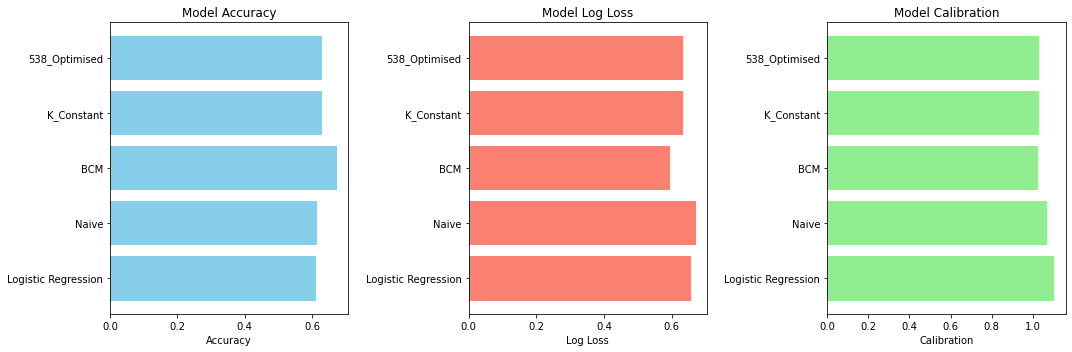

,model,pred_acc,log_loss,calibration
0,Logistic Regression,0.610900,0.656600,1.104400
1,Naive,0.613793,0.670787,1.067783
2,BCM,0.673946,0.594676,1.023090
3,K_Constant,0.629772,0.633985,1.028118
4,538_Optimised,0.630158,0.633003,1.032392


In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Single Feature Logistic Regression Model Results
single_feature_results = {
    'model': ['Logistic Regression'],
    'pred_acc': [0.6109],
    'log_loss': [0.6566],
    'calibration': [1.1044]
}

# Naive Model Results
naive_model_results = {
    'model': ['Naive'],
    'pred_acc': [0.613793],
    'log_loss': [0.670787],
    'calibration': [1.067783]
}

# BCM Model Results
bcm_model_results = {
    'model': ['BCM'],
    'pred_acc': [0.6739463601532567],
    'log_loss': [0.5946757499493406],
    'calibration': [1.0230901760739093]
}

# Other Models Results
other_models_results = {
    'model': ['K_Constant', '538_Optimised'],
    'pred_acc': [0.629772, 0.630158],
    'log_loss': [0.633985, 0.633003],
    'calibration': [1.028118, 1.032392]
}

# Combine all results into a single dataframe
single_feature_df = pd.DataFrame(single_feature_results)
naive_model_df = pd.DataFrame(naive_model_results)
bcm_model_df = pd.DataFrame(bcm_model_results)
other_models_df = pd.DataFrame(other_models_results)

results_df = pd.concat([single_feature_df, naive_model_df, bcm_model_df, other_models_df], ignore_index=True)

# Plotting
plt.figure(figsize=(15, 5))

# Plot for Accuracy
plt.subplot(1, 3, 1)
plt.barh(results_df['model'], results_df['pred_acc'], color='skyblue')
plt.xlabel('Accuracy')
plt.title('Model Accuracy')

# Plot for Log Loss
plt.subplot(1, 3, 2)
plt.barh(results_df['model'], results_df['log_loss'], color='salmon')
plt.xlabel('Log Loss')
plt.title('Model Log Loss')

# Plot for Calibration
plt.subplot(1, 3, 3)
plt.barh(results_df['model'], results_df['calibration'], color='lightgreen')
plt.xlabel('Calibration')
plt.title('Model Calibration')

plt.tight_layout()
plt.show()

# Display the results dataframe
results_df


In [9]:
# Display the results dataframe sorted by log_loss in ascending order
results_df_sorted = results_df.sort_values(by='log_loss', ascending=True)
results_df_sorted

,model,pred_acc,log_loss,calibration
2,BCM,0.673946,0.594676,1.023090
4,538_Optimised,0.630158,0.633003,1.032392
3,K_Constant,0.629772,0.633985,1.028118
0,Logistic Regression,0.610900,0.656600,1.104400
1,Naive,0.613793,0.670787,1.067783


## Extension 1:

In [10]:
# Load your dataset
df = betting_data_test

# Define function to filter dataset for top N players
def filter_top_players(df, top_n):
    df_top = df[(df['WRank'] <= top_n) | (df['LRank'] <= top_n)]
    return df_top

# Filter the dataset for top 50 and top 100 players
df_top_50 = filter_top_players(df, 50)
df_top_100 = filter_top_players(df, 100)

# Calculate metrics for top 50 players
top_50_accuracy, top_50_log_loss, top_50_calibration = calculate_metrics(df_top_50, naive_accuracy_train)

# Calculate metrics for top 100 players
top_100_accuracy, top_100_log_loss, top_100_calibration = calculate_metrics(df_top_100, naive_accuracy_train)

# Store the results for the testing set, top 50, and top 100
validation_stats_test = pd.DataFrame({
    'model': ['naive_test', 'naive_top_50', 'naive_top_100'],
    'pred_acc_test': [naive_accuracy_test, top_50_accuracy, top_100_accuracy],
    'log_loss': [log_loss_naive_test, top_50_log_loss, top_100_log_loss],
    'calibration': [calibration_naive_test, top_50_calibration, top_100_calibration]
})

# Display the validation statistics
print("Validation Stats (Entire Dataset):")
print(validation_stats)

print("\nValidation Stats (Test, Top 50, Top 100):")
print(validation_stats_test)


Validation Stats (Entire Dataset):
   model  pred_acc  log_loss  calibration
0  naive  0.659668  0.641255          1.0

Validation Stats (Test, Top 50, Top 100):
           model  pred_acc_test  log_loss  calibration
0     naive_test       0.613961  0.672167     1.079554
1   naive_top_50       0.634773  0.658102     1.044159
2  naive_top_100       0.615044  0.671435     1.077652
